In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import curve_fit
%matplotlib inline

In [4]:
def evolveStates(initStates, timeSteps, precessionFreq):
    # Get array sizes for convinience
    num_states = np.size(initStates)
    num_timeSteps = np.size(timeSteps)
    
    # Calculate the phase advancements
    added_phase = 360 * timeSteps * precessionFreq
    # Copy initial states across different timesteps
    states = np.transpose(np.reshape(np.tile(initStates, num_timeSteps), [num_timeSteps,num_states]))
    # Copy the phases to be added across different states
    phases = np.reshape(np.tile(added_phase, num_states), [num_states,num_timeSteps])
    
    return states + phases

In [5]:
def applyRandomPhaseJumps(states, timeSteps, jumpPeriod, jumpAmplMean, jumpAmplStdev):
    # Get array sizes for convinience
    num_states = np.size(states[:,0])
    num_timeSteps = np.size(timeSteps)
    # Jump parameters
    deltaT = np.max(timeSteps) - np.min(timeSteps)
    averageNumJumps = deltaT / jumpPeriod
    # Jump statistics
    numJumpStats = np.zeros(num_states)
    totalPhaseShiftStats = np.zeros(num_states)
    
    # Loop through each state in order to apply jump events
    for stateIndex in np.arange(1, num_states+1, 1)-1:
        # Number of jumps determined by a Poisson distribution
        numJumps = np.random.poisson(lam=averageNumJumps)
        numJumpStats[stateIndex] = numJumps
        # Generate some jump event timestamps
        jumpEvents = generateEvents(timeSteps, numJumps)
        # Store phase jump amplitudes
        jumpAmplStats = np.array([])
        # Loop through the jump events
        for jumpTS in jumpEvents:
            # Apply each jump
            jumpAmpl = np.random.normal(loc=jumpAmplMean, scale=jumpAmplStdev)
            jumpAmplStats = np.append(jumpAmplStats, jumpAmpl)
            states[stateIndex] = applyJump(states[stateIndex], timeSteps, jumpTS, jumpAmpl)
        # Total phase shift per state
        totalPhaseShiftStats[stateIndex] = np.sum(jumpAmplStats)
    
    return states, numJumpStats, totalPhaseShiftStats

In [6]:
def applyJump(state, timeSteps, timeStamp, jumpAmpl):
    # Index of first timeStep greater than timeStamp
    jumpIndex = np.argmax(timeSteps>=timeStamp)
    # Copy of state
    newState = state
    # Update state with jump after timeStamp
    newState[jumpIndex:np.size(newState)] = newState[jumpIndex:np.size(newState)] + jumpAmpl
    return newState

In [7]:
def generateEvents(timeSteps, numEvents):
    return np.random.uniform(low=np.min(timeSteps), high=np.max(timeSteps), size=numEvents)

# Rydberg - NH3 collision simulation

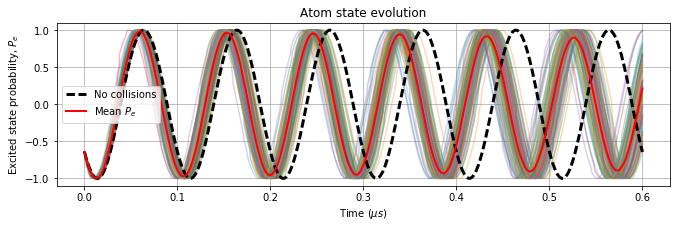

In [22]:
# numAtoms = 100
# initPhase = 220
# startTime = 0.0
# endTime = 0.6
# precessionFreq = 10.0
# jumpPeriod = 0.02
# jumpAmplMean = 5.0
# jumpAmplStdev = 2.0

def phase_jump_simulation(numAtoms, initPhase, startTime, endTime, precessionFreq, jumpPeriod, jumpAmplMean, jumpAmplStdev):
    initStates = np.zeros(numAtoms) + initPhase
    timeSteps = np.linspace(startTime, endTime, 1000) # us

    evolved_states = evolveStates(initStates, timeSteps, precessionFreq)
    [collision_states, numJumpStats, totalPhaseShiftStats] = applyRandomPhaseJumps(
        evolved_states, timeSteps, jumpPeriod, jumpAmplMean, jumpAmplStdev)

    matplotlib.rcParams['figure.figsize'] = (11.0, 3.0)

    plotStartI = int(np.floor(np.size(timeSteps) * 0.00 ))
    plotEndI   = int(np.floor(np.size(timeSteps) * 1.00 ))

    for stateIndex in np.arange(1, numAtoms+1, 1)-1:
        plt.plot(timeSteps[plotStartI:plotEndI], np.sin(np.radians(collision_states[stateIndex]))[plotStartI:plotEndI],
                 alpha=0.3)

    no_collisions = np.sin(2*np.pi * timeSteps * precessionFreq + np.radians(initPhase) )
    plt.plot(timeSteps[plotStartI:plotEndI], no_collisions[plotStartI:plotEndI], 'k--', lw=3, label='No collisions')
    mean_pe = np.mean(np.sin(np.radians(collision_states)), axis=0)
    plt.plot(timeSteps[plotStartI:plotEndI], mean_pe[plotStartI:plotEndI], 'r-', lw=2, label='Mean $P_e$')

    plt.xlabel('Time ($\mu s$)')
    plt.ylabel('Excited state probability, $P_e$')
    plt.title('Atom state evolution')
    plt.grid()
    plt.legend()
    
    return [timeSteps, mean_pe], [numJumpStats, totalPhaseShiftStats]
    
# results, stats = phase_jump_simulation(numAtoms, initPhase, startTime, endTime, precessionFreq, jumpPeriod, jumpAmplMean, jumpAmplStdev)

# Statistics

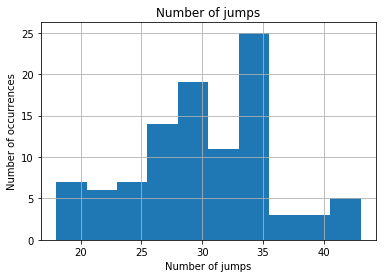

In [14]:
def stats_num_jumps(stats):
    matplotlib.rcParams['figure.figsize'] = (6.0, 4.0)
    plt.hist(stats[0])
    plt.xlabel('Number of jumps')
    plt.ylabel('Number of occurrences')
    plt.title('Number of jumps')
    plt.grid()

# stats_num_jumps(stats)

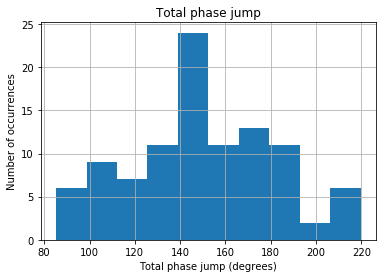

In [15]:
def stats_phase_jumps(stats):
    matplotlib.rcParams['figure.figsize'] = (6.0, 4.0)
    plt.hist(stats[1])
    plt.xlabel('Total phase jump (degrees)')
    plt.ylabel('Number of occurrences')
    plt.title('Total phase jump')
    plt.grid()
    
# stats_phase_jumps(stats)

# Curve fit

In [18]:
def decayingSinModel(time, freq, T_decay, amp, phase, offset):
    # Linearly decaying sinusoidal function
    return amp * np.exp(-time/T_decay) * np.sin(2*np.pi*( freq*time ) + np.radians(phase)) + offset

In [19]:
def phase_jump_simulation_fit_guess_default():
    freq_guess = precessionFreq
    T_decay_guess = 1
    amp_guess = 2
    phase_guess = 0
    offset_guess = 0
    return [freq_guess, T_decay_guess, amp_guess, phase_guess, offset_guess]

The fitted value of  Frequency  is  10.7164262769  with error  0.000554674524442
The fitted value of  T decay  is  5.43024261952  with error  0.101079538432
The fitted value of  Amplitude  is  0.994979082313  with error  0.0011331428943
The fitted value of  Phase  is  -139.174253138  with error  0.0681942414449
The fitted value of  Offset  is  -0.00160461883792  with error  0.000399435188576


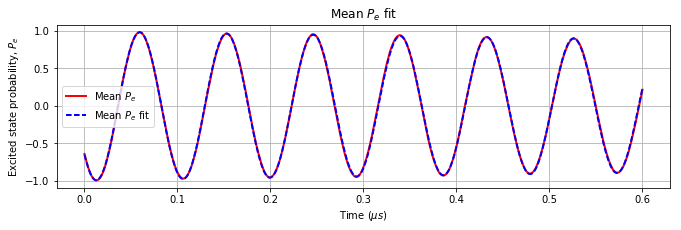

In [23]:
def phase_jump_simulation_fit(results, guess=phase_jump_simulation_fit_guess_default()):
    timeSteps = results[0]
    mean_pe = results[1]
    popt,pcov = curve_fit(decayingSinModel, timeSteps, mean_pe, p0=guess)

    perr = np.sqrt(np.diag(pcov))
    params = ['Frequency', 'T decay', 'Amplitude', 'Phase', 'Offset']

    for idx in range(len(params)):
        print( "The fitted value of ", params[idx], " is ", popt[idx], " with error ", perr[idx] )

    matplotlib.rcParams['figure.figsize'] = (11.0, 3.0)

    mean_pe_fit = decayingSinModel(timeSteps, *popt)
    plt.plot(timeSteps, mean_pe, 'r-', lw=2, label='Mean $P_e$')
    plt.plot(timeSteps, mean_pe_fit, 'b--', lw=2, label='Mean $P_e$ fit')

    plt.xlabel('Time ($\mu s$)')
    plt.ylabel('Excited state probability, $P_e$')
    plt.title('Mean $P_e$ fit')
    plt.grid()
    plt.legend()
    
# phase_jump_simulation_fit(results)